# Model Performance Reporting Notebook

This notebook generates comprehensive evaluation reports for each AI-based evaluator model. It reads the `*_evaluations.csv` files produced by the `5_Evaluation.ipynb` pipeline, computes summary statistics, inter-rater reliability metrics (Cohen's Kappa), component-specific distance averages, and domain-specific distance averages, and writes a neatly formatted Markdown report for each model into the `model_reports/` directory.

**Notebook Structure**:
1. Imports and Setup
2. Directory Configuration
3. Helper Functions
4. Load Framework & Human Evaluations
5. Report Generation Function
6. Execute Report Generation
7. Reliability Exam Functions
8. Reliability Exam Visualizations
9. Execute Reliability Exams and Generate Visualizations

_Note: Make sure you have run `5_Evaluation.ipynb` and that the `model_evaluation_data/` folder contains your `*_evaluations.csv` files, and that you have access to your human evaluation data (`peru_cleaned_transcripts.csv`) and framework JSON (`Teach_1.json`)._

In [1]:
# 1. Imports and Setup
import os
import glob
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import cohen_kappa_score
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 2. Directory Configuration

Define paths for input evaluation CSVs and output reports, and ensure the output directory exists.

In [2]:
# Directories
import sys
import os
from pathlib import Path

sys.path.append('/Users/mkrasnow/Desktop/montesa')

EVALS_DIR = 'model_evaluation_data'
REPORTS_DIR = 'model_reports'
VIZ_DIR = 'model_visualizations'
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)
print(f"Input evaluations directory: {EVALS_DIR}")
print(f"Output reports directory:    {REPORTS_DIR}")
print(f"Visualizations directory:    {VIZ_DIR}")

Input evaluations directory: model_evaluation_data
Output reports directory:    model_reports
Visualizations directory:    model_visualizations


## 3. Helper Functions

Define utility functions for converting labels to numeric, computing normalized distances, and computing Cohen's Kappa.

In [3]:
def alpha_to_numeric(x):
    """
    Convert string labels to numeric values:
      - 'Y'/'y'/'Yes'/'1' -> 1.0
      - 'N'/'n'/'No'/'0'  -> 0.0
      - 'N/A' or empty   -> np.nan
      - 'L' -> 1.0, 'M' -> 2.0, 'H' -> 3.0
      - Numeric strings convertible to float -> float(x)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s in {'Y','y','Yes','1'}:
        return 1.0
    if s in {'N','n','No','0'}:
        return 0.0
    if s in {'N/A','','NA','na','nan'}:
        return np.nan
    if s in {'L','M','H'}:
        return {'L':1.0,'M':2.0,'H':3.0}[s]
    try:
        return float(s)
    except ValueError:
        return np.nan

def component_distance(human_score, ai_score, score_type):
    """
    Compute normalized distance between human and AI scores.
    score_type: 'YN' (max 1), 'LMH' (max 2), 'NUM' (1-5 scale, max diff 4).
    Returns float in [0,1].
    """
    h = alpha_to_numeric(human_score)
    a = alpha_to_numeric(ai_score)
    if math.isnan(h) and math.isnan(a):
        return 0.0
    if math.isnan(h) ^ math.isnan(a):
        return 1.0
    if score_type == 'YN':
        dmax = 1.0
    elif score_type == 'LMH':
        dmax = 2.0
    else:
        dmax = 4.0
    return min(max(abs(h - a) / dmax, 0.0), 1.0)

def encode_for_kappa(series, score_list):
    """Map categorical labels to integers for Cohen's Kappa."""
    mapping = {str(lbl): i for i, lbl in enumerate(score_list)}
    na_idx = mapping.get('N/A')
    def map_val(x):
        x_str = str(x)
        if x_str in mapping:
            return mapping[x_str]
        return na_idx if na_idx is not None else np.nan
    return series.map(map_val)

def compute_component_kappa(human_series, ai_series, score_list, weight=None):
    """Compute Cohen's Kappa for a single component."""
    h_enc = encode_for_kappa(human_series, score_list)
    a_enc = encode_for_kappa(ai_series, score_list)
    mask = ~(h_enc.isna() | a_enc.isna())
    if mask.sum() == 0:
        return np.nan
    if weight is None:
        numeric_labels = all(str(lbl).isdigit() for lbl in score_list) and len(score_list) > 2
        if any(lbl in ['L','M','H'] for lbl in score_list) or numeric_labels:
            weight = 'quadratic'
    return cohen_kappa_score(h_enc[mask], a_enc[mask], weights=weight)

def compute_distances_for_item(human_row, ai_row, framework):
    """
    Compute domain-level and overall normalized distances for one item.
    Returns (domain_distances: dict(domain_id->float), overall_distance:float).
    """
    domain_dist = {}
    num = 0.0
    wsum = 0.0
    for domain in framework['structure']['domains']:
        did = str(domain['id'])
        dnum = 0.0
        dwsum = 0.0
        stype = 'NUM'
        for comp in domain['components']:
            cname = comp['name']
            cweight = float(comp.get('weight',1.0))
            sl = comp.get('scoreList', [])
            if set(sl) <= {'Y','N','N/A'}:
                stype = 'YN'
            elif set(sl) <= {'L','M','H','N/A'}:
                stype = 'LMH'
            d = component_distance(human_row.get(cname), ai_row.get(cname), stype)
            dnum += cweight * d
            dwsum += cweight
        Dd = (dnum / dwsum) if dwsum>0 else 0.0
        domain_dist[did] = Dd
        num += float(domain.get('weight',1.0)) * Dd
        wsum += float(domain.get('weight',1.0))
    overall = (num/wsum) if wsum>0 else 0.0
    return domain_dist, overall

## 4. Load Framework & Human Evaluations

Functions to load the evaluation framework JSON and the cleaned transcripts with human evaluation scores.

In [4]:
from pathlib import Path

def load_framework(path):
    with open(path, 'r') as f:
        return json.load(f)

def load_human_evaluations(cleaned_csv_path, framework_json_path):
    df = pd.read_csv(cleaned_csv_path, dtype=str)
    # Extract base_id and clip_number
    clip_info = df['School_Clip'].str.extract(r'(?P<base_id>\d{6,7})\s*Clip\s*(?P<clip_num>[12])')
    df['base_id'] = clip_info['base_id']
    df['clip_number'] = clip_info['clip_num'].map({'1':'first','2':'last'})
    # Determine evaluation columns from framework
    framework = load_framework(framework_json_path)
    eval_cols = []
    for domain in framework['structure']['domains']:
        for comp in domain['components']:
            if comp['name'] in df.columns:
                eval_cols.append(comp['name'])
    return df[['base_id','clip_number'] + eval_cols]

# Example paths (adjust as needed)
FRAMEWORK_PATH   = '/Users/mkrasnow/Desktop/montesa/new/models/_context/Teach_1.json'
TRANSCRIPTS_PATH = '/Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv'

## 5. Report Generation Function

This function iterates over each `*_evaluations.csv` file, computes all metrics, and writes a Markdown report for each model.

In [5]:
def generate_reports(framework_path, transcripts_path, evals_dir, reports_dir):
    framework = load_framework(framework_path)
    human_df  = load_human_evaluations(transcripts_path, framework_path)

    # Gather component definitions
    components = []
    for domain in framework['structure']['domains']:
        for comp in domain['components']:
            components.append({
                'id': str(comp['id']),
                'name': comp['name'],
                'score_list': comp.get('scoreList', ['Y','N','N/A'])
            })

    # Process each evaluation CSV
    for eval_file in glob.glob(os.path.join(evals_dir, '*_evaluations.csv')):
        model_name = os.path.basename(eval_file).replace('_evaluations.csv','')
        ai_df = pd.read_csv(eval_file, dtype=str)

        # Compute distances for each item and track agreement
        dist_records = []
        for _, row in ai_df.iterrows():
            hr = human_df[(human_df.base_id==row.base_id)&(human_df.clip_number==row.clip_number)]
            if hr.empty: continue
            hr = hr.iloc[0]
            dom_dist, overall = compute_distances_for_item(hr, row, framework)
            rec = {'base_id':row.base_id,'clip_number':row.clip_number,'overall_distance':overall}
            for did, dval in dom_dist.items(): rec[f'domain_{did}_dist'] = dval
            dist_records.append(rec)
        distances_df = pd.DataFrame(dist_records)
        # Add LLM-human agreement column (accuracy) as 1 - distance
        distances_df['agreement'] = 1 - distances_df['overall_distance']

        # Summary statistics for distance and agreement
        overall_stats = distances_df['overall_distance'].describe()
        agreement_stats = distances_df['agreement'].describe()

        # Component-wise Cohen's Kappa
        kappa_records = []
        for comp in components:
            comp_name = comp['name']
            # Skip if component not present in either AI or human evaluations
            if comp_name not in ai_df.columns or comp_name not in human_df.columns:
                continue
            h_ser = human_df[comp_name]
            a_ser = ai_df[comp_name]
            numeric_labels = all(str(lbl).isdigit() for lbl in comp['score_list']) and len(comp['score_list']) > 2
            weight = 'quadratic' if any(lbl in ['L','M','H'] for lbl in comp['score_list']) or numeric_labels else None
            try:
                k = compute_component_kappa(h_ser, a_ser, comp['score_list'], weight)
            except:
                k = np.nan
            kappa_records.append({'component_name': comp_name, 'kappa': k})
        kappa_df = pd.DataFrame(kappa_records)

        # Component-specific distance averages
        comp_dist_avgs = []
        for comp in components:
            cname = comp['name']
            # Skip if component not present in either AI or human evaluations
            if cname not in ai_df.columns or cname not in human_df.columns:
                continue
            # Compute mean normalized diff per component
            diffs = ai_df.apply(lambda r: component_distance(
                human_df[(human_df.base_id == r.base_id) & (human_df.clip_number == r.clip_number)].iloc[0].get(cname),
                r.get(cname),
                'YN' if set(comp['score_list']) <= {'Y', 'N', 'N/A'} else ('LMH' if set(comp['score_list']) <= {'L', 'M', 'H', 'N/A'} else 'NUM')
            ), axis=1)
            comp_dist_avgs.append({'component_name': cname, 'avg_distance': diffs.mean()})
        comp_dists_df = pd.DataFrame(comp_dist_avgs)

        # Domain-specific distance averages
        domain_avgs = []
        for domain in framework['structure']['domains']:
            did = str(domain['id'])
            col = f'domain_{did}_dist'
            if col in distances_df.columns:
                domain_avgs.append({'domain_id':did,'domain_name':domain['name'],'avg_distance':distances_df[col].mean()})
        domain_dists_df = pd.DataFrame(domain_avgs)

        # Build Markdown report
        lines = []
        lines.append(f"# Report for Model: **{model_name}**\n")
        lines.append("## 1. Distance and LLM-Human Agreement Summary Statistics\n")
        lines.append("### 1.1 Overall Distance\n")
        lines.append(overall_stats.to_markdown() + "\n")
        lines.append("### 1.2 LLM-Human Agreement\n")
        lines.append(agreement_stats.to_markdown() + "\n")
        lines.append("## 2. Inter-Rater Reliability (Cohen's Kappa)\n")
        lines.append(kappa_df.to_markdown(index=False) + "\n")
        lines.append("## 3. Component-Specific Distance Averages\n")
        lines.append(comp_dists_df.to_markdown(index=False) + "\n")
        lines.append("## 4. Domain-Specific Distance Averages\n")
        lines.append(domain_dists_df.to_markdown(index=False) + "\n")

        report_md = "\n".join(lines)
        out_path = os.path.join(reports_dir, f"{model_name}_report.md")
        with open(out_path, 'w') as f:
            f.write(report_md)
        print(f"✅ Written report for {model_name} → {out_path}")

## 6. Execute Report Generation

Run the `generate_reports` function with your configured paths.

In [6]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [7]:
generate_reports(
    framework_path=FRAMEWORK_PATH,
    transcripts_path=TRANSCRIPTS_PATH,
    evals_dir=EVALS_DIR,
    reports_dir=REPORTS_DIR,
)

print("\nAll model reports generated successfully.")

✅ Written report for 4-BaseEvaluator-Validate-no-NA-data → model_reports/4-BaseEvaluator-Validate-no-NA-data_report.md
✅ Written report for 5-BaseEvaluator-Validate-no-NA-data-g-25-flash → model_reports/5-BaseEvaluator-Validate-no-NA-data-g-25-flash_report.md
✅ Written report for 1-BaseEvaluator → model_reports/1-BaseEvaluator_report.md
✅ Written report for 2-BaseEvaluator-Validate → model_reports/2-BaseEvaluator-Validate_report.md
✅ Written report for 3-BaseEvaluator-Validate-no-NA → model_reports/3-BaseEvaluator-Validate-no-NA_report.md

All model reports generated successfully.


## 7. Reliability Exam Functions

Evaluate AI models against the Teach Reliability Exam criteria:
- **Time on Learning**: exact agreement on 2 of 3 snapshots per segment.
- **Quality Elements**: within 1 point of master codes on at least 8 of 9 high-inference elements per segment.

Two evaluation versions are implemented:
1. **Random Set Exam**: Two attempts with random sets of three segments.
2. **Average Exam**: Compute exam metrics across all available segments.

In [8]:
# Reliability Exam Functions
# Reliability Exam Functions
import random

# Define columns for Time on Learning snapshots and Quality elements
snapshot_teacher = [
    'Teacher provides learning activity - 1st Snapshot',
    'Teacher provides learning activity - 2nd Snapshot',
    'Teacher provides learning activity - 3rd Snapshot'
]
snapshot_students = [
    'Students are on task - 1st Snapshot',
    'Students are on task - 2nd Snapshot',
    'Students are on task - 3rd Snapshot'
]
quality_elements = [
    'Supportive Learning Environment',
    'Positive Behavioral Expectations',
    'Lesson Facilitation',
    'Checks for understanding',
    'Feedback',
    'Critical Thinking',
    'Autonomy',
    'Perseverance',
    'Social & Collaborative Skills'
]

def evaluate_segment(ai_row, human_row):
    """
    Returns True if the segment is reliable on at least
    8 of the 10 elements (time snapshots count as 1 element).
    """
    # 1. Time on Learning element (1 point)
    time_agreements = []
    for t_col, s_col in zip(snapshot_teacher, snapshot_students):
        t_match = ai_row[t_col] == human_row[t_col]
        s_match = ai_row[s_col] == human_row[s_col]
        time_agreements.append(t_match and s_match)
    time_ok = sum(time_agreements) >= 2
    # 2. Quality elements (up to 9 points)
    quality_agreements = []
    for col in quality_elements:
        h = alpha_to_numeric(human_row[col])
        a = alpha_to_numeric(ai_row[col])
        if math.isnan(h) or math.isnan(a):
            quality_agreements.append(False)
        else:
            quality_agreements.append(abs(h - a) <= 1.0)
    quality_count = sum(quality_agreements)
    # 3. Total reliable elements
    total_reliable = (1 if time_ok else 0) + quality_count
    # Pass if at least 8 of 10
    return total_reliable >= 8


def run_random_exam(models, ai_df, human_df, attempts=2, set_size=3, seed=42):
    random.seed(seed)
    results = {}
    for model in models:
        df_m = ai_df[ai_df['model_name'] == model]
        keys = df_m[['base_id','clip_number']].drop_duplicates().apply(tuple, axis=1).tolist()
        certified = False
        attempt_results = []
        for att in range(1, attempts+1):
            sample = random.sample(keys, k=set_size)
            passed_all = True
            for seg in sample:
                row_ai = df_m[(df_m['base_id'] == seg[0]) & (df_m['clip_number'] == seg[1])].iloc[0]
                row_h  = human_df[(human_df['base_id'] == seg[0])  & (human_df['clip_number'] == seg[1])].iloc[0]
                seg_pass = evaluate_segment(row_ai, row_h)
                if not seg_pass:
                    passed_all = False
                    break
            attempt_results.append({'attempt': att, 'passed': passed_all, 'segments': sample})
            if passed_all:
                certified = True
                break
        results[model] = {'certified': certified, 'attempts': attempt_results}
    return results


def run_average_exam(models, ai_df, human_df):
    """
    Computes the proportion of segments each model passes (>=8/10 elements).
    """
    results = {}
    for model in models:
        df_m = ai_df[ai_df['model_name'] == model]
        pass_list = []
        for _, row_ai in df_m.iterrows():
            row_h = human_df[
                (human_df['base_id'] == row_ai['base_id']) &
                (human_df['clip_number'] == row_ai['clip_number'])
            ].iloc[0]
            seg_pass = evaluate_segment(row_ai, row_h)
            pass_list.append(seg_pass)
        pass_rate = sum(pass_list) / len(pass_list) if pass_list else float('nan')
        results[model] = {'pass_rate': pass_rate}
    return results

## 8. Reliability Exam Visualizations

Create comprehensive visualizations for reliability exam results that are robust to handle any number of models.

In [9]:
def create_exam_performance_dashboard(avg_results, random_results, save_path=None):
    """
    Create a dashboard showing overall segment pass rate (>=8/10 elements)
    and random‐exam certification status.
    """
    models = list(avg_results.keys())
    n_models = len(models)

    # Overall pass rates
    pass_rates = [avg_results[model]['pass_rate'] * 100 for model in models]

    # Setup figure
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.4)

    # 1. Pass Rate Bar Chart
    ax1 = fig.add_subplot(gs[0])
    x = np.arange(n_models)
    bars = ax1.bar(x, pass_rates)
    # TEACH certification requires ≥80% element reliability per segment
    ax1.axhline(80, color='red', linestyle='--', linewidth=2,
                label='Certification Threshold (80%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.set_ylabel('Segment Pass Rate (%)')
    ax1.set_title('Average Segment Pass Rate by Model')
    ax1.set_ylim(0, 100)
    ax1.legend()

    # Label values on bars
    for bar, rate in zip(bars, pass_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, rate + 1,
                 f'{rate:.1f}%', ha='center', va='bottom')

    # 2. Certification Status Pie Chart
    ax2 = fig.add_subplot(gs[1])
    certified = [random_results[m]['certified'] for m in models]
    counts = [sum(certified), n_models - sum(certified)]
    ax2.pie(counts, labels=['Certified','Failed'], autopct='%d', startangle=90)
    ax2.set_title('Random Exam Certification')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

def create_performance_progression_chart(avg_results, save_path=None):
    """
    Create a line chart showing pass_rate progression across models.
    """
    models = list(avg_results.keys())
    pass_rates = [avg_results[m]['pass_rate'] * 100 for m in models]

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(models))
    ax.plot(x, pass_rates, marker='o', linewidth=2)
    # Adjust to 80% threshold
    ax.axhline(80, color='red', linestyle='--', linewidth=1.5,
               label='Certification Threshold (80%)')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylim(0, 100)
    ax.set_ylabel('Segment Pass Rate (%)')
    ax.set_title('Model Pass Rate Progression')
    ax.legend()

    for i, rate in enumerate(pass_rates):
        ax.annotate(f'{rate:.1f}%', (i, rate), textcoords='offset points',
                    xytext=(0,8), ha='center')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig


def create_detailed_metrics_table(avg_results, random_results, save_path=None):
    """
    Build a table of pass rates and certification status for each model.
    """
    data = []
    for model, stats in avg_results.items():
        pr = stats['pass_rate'] * 100
        cert = random_results[model]['certified']
        data.append({
            'Model': model,
            'Pass Rate (%)': f"{pr:.1f}",
            'Certified': 'Yes' if cert else 'No'
        })

    df = pd.DataFrame(data)

    # Render as a matplotlib table
    fig, ax = plt.subplots(figsize=(8,  len(df)*0.5 + 1))
    ax.axis('tight')
    ax.axis('off')
    tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1, 1.5)

    # Highlight certification status
    for i, cert in enumerate(df['Certified'], start=1):
        color = '#90EE90' if cert=='Yes' else '#FFB6C1'
        tbl[(i, df.columns.get_loc('Certified'))].set_facecolor(color)

    plt.title('Model Pass Rates & Certification', pad=20)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig, df


## 9. Execute Reliability Exams and Generate Visualizations

Run the reliability exams and create comprehensive visualizations for all models.

In [10]:
# Execute Reliability Exams and Generate Visualizations
print("🔍 Loading evaluation data for reliability exams...")

# Get all models dynamically
models = [os.path.basename(f).replace('_evaluations.csv','') 
          for f in glob.glob(os.path.join(EVALS_DIR, '*_evaluations.csv'))]

print(f"📊 Found {len(models)} models for evaluation: {models}")

# Load all AI evaluation data and add model names
ai_dfs = []
for f in glob.glob(os.path.join(EVALS_DIR, '*_evaluations.csv')):
    model_name = os.path.basename(f).replace('_evaluations.csv','')
    df = pd.read_csv(f, dtype=str)
    df['model_name'] = model_name
    ai_dfs.append(df)

ai_df_all = pd.concat(ai_dfs, ignore_index=True)
human_df_all = load_human_evaluations(TRANSCRIPTS_PATH, FRAMEWORK_PATH)

print("\n🎯 Running Random Certification Exams...")
random_results = run_random_exam(models, ai_df_all, human_df_all)
print("Random Exam Results:")
print(random_results)

print("\n📈 Running Average Performance Exams...")
avg_results = run_average_exam(models, ai_df_all, human_df_all)
print("Average Exam Results:")
print(avg_results)

print("\n🎨 Generating comprehensive visualizations...")

🔍 Loading evaluation data for reliability exams...
📊 Found 5 models for evaluation: ['4-BaseEvaluator-Validate-no-NA-data', '5-BaseEvaluator-Validate-no-NA-data-g-25-flash', '1-BaseEvaluator', '2-BaseEvaluator-Validate', '3-BaseEvaluator-Validate-no-NA']

🎯 Running Random Certification Exams...
Random Exam Results:
{'4-BaseEvaluator-Validate-no-NA-data': {'certified': True, 'attempts': [{'attempt': 1, 'passed': True, 'segments': [('268516', 'last'), ('283416', 'first'), ('259358', 'first')]}]}, '5-BaseEvaluator-Validate-no-NA-data-g-25-flash': {'certified': True, 'attempts': [{'attempt': 1, 'passed': True, 'segments': [('838565', 'last'), ('389163', 'first'), ('723288', 'last')]}]}, '1-BaseEvaluator': {'certified': False, 'attempts': [{'attempt': 1, 'passed': False, 'segments': [('320978', 'first'), ('283416', 'last'), ('269860', 'last')]}, {'attempt': 2, 'passed': False, 'segments': [('237990', 'first'), ('829457', 'first'), ('269860', 'last')]}]}, '2-BaseEvaluator-Validate': {'certif


📊 Creating Performance Dashboard...


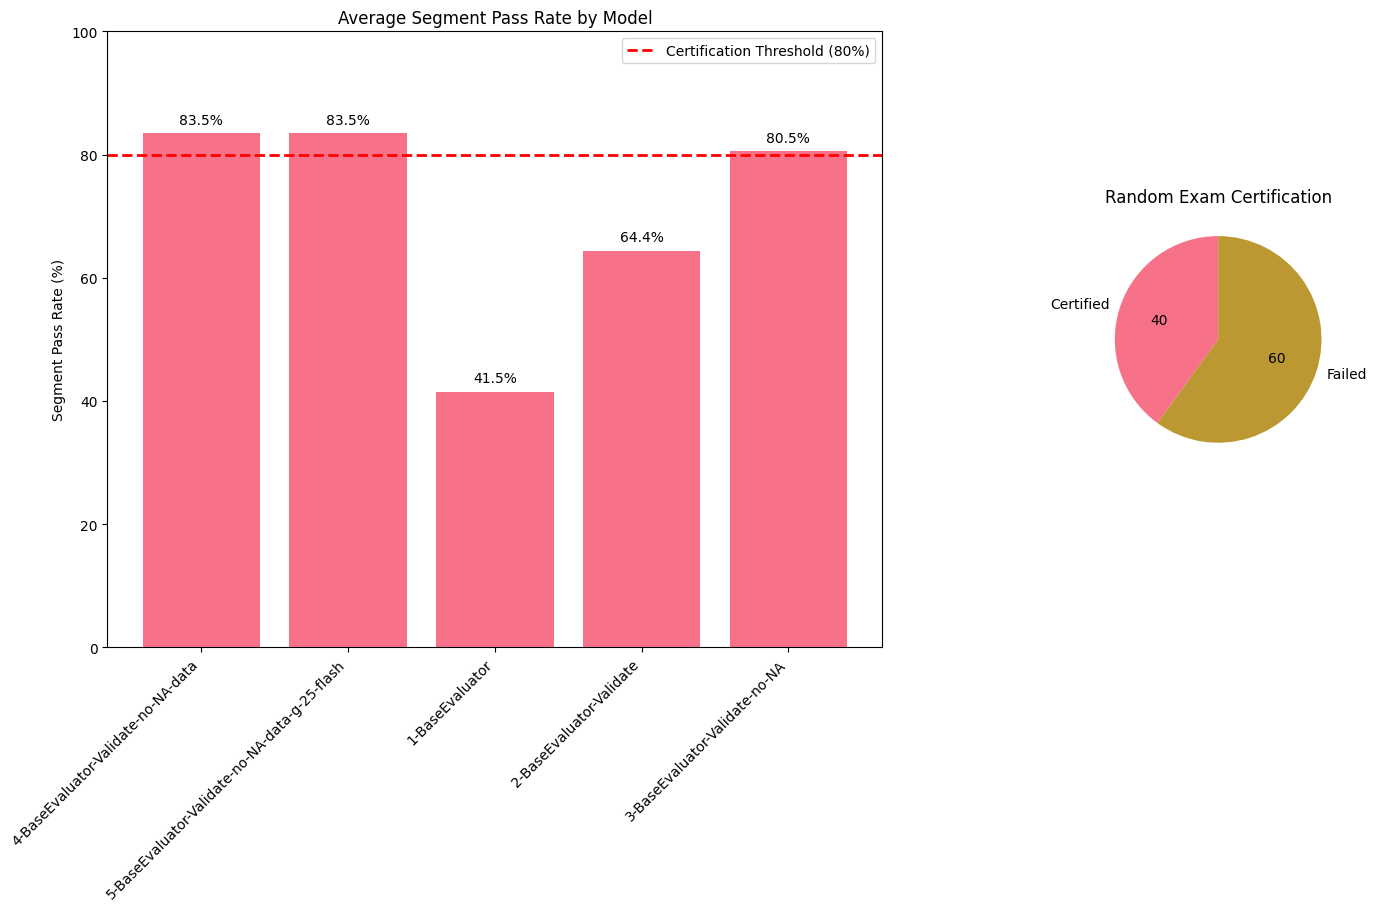


📈 Creating Performance Progression Chart...


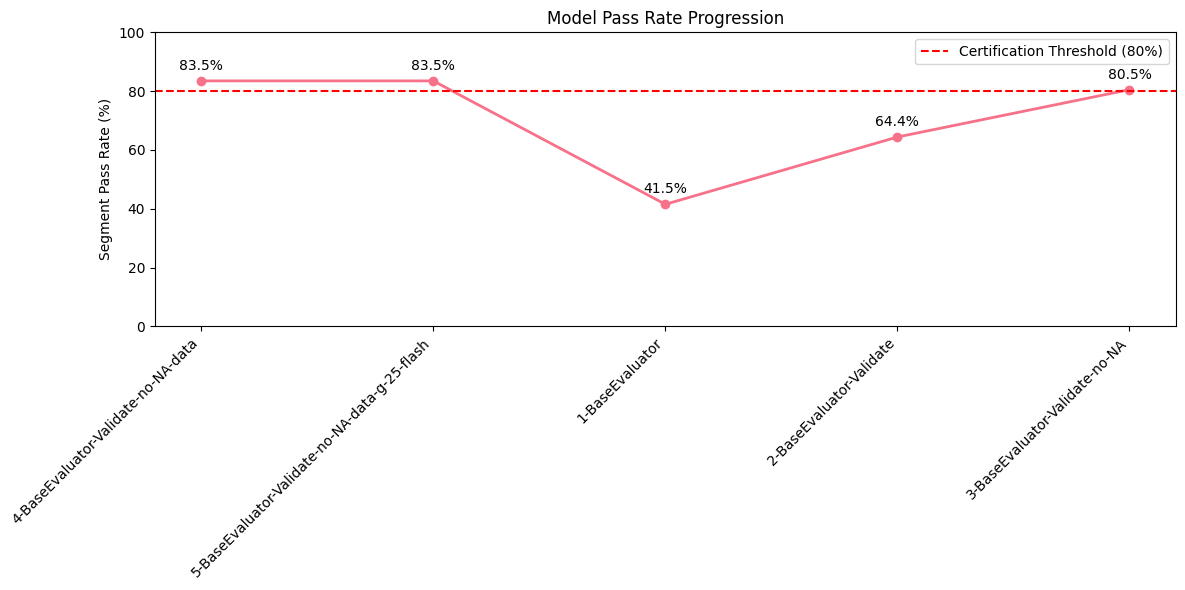


📋 Creating Detailed Metrics Table...


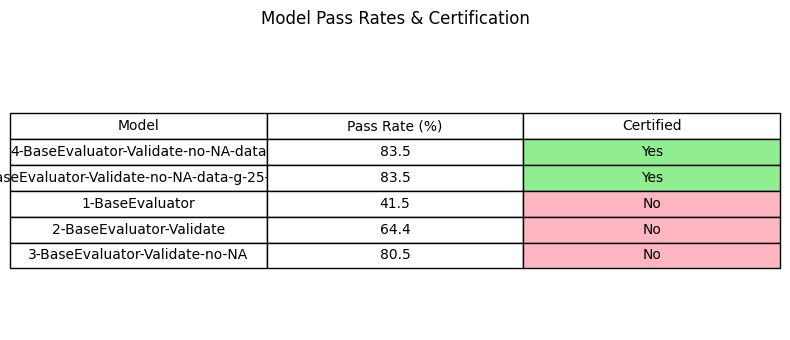

✅ Metrics CSV saved to: model_visualizations/model_performance_metrics.csv

🎉 All visualizations completed successfully!

📁 Visualizations saved to: model_visualizations
Files generated:
  - detailed_metrics_table.png
  - model_performance_metrics.csv
  - model_progression_chart.png
  - reliability_exam_dashboard.png
  - reliability_exam_summary.txt


In [11]:
# Generate all visualizations

# 1. Main Performance Dashboard
print("\n📊 Creating Performance Dashboard...")
dashboard_path = os.path.join(VIZ_DIR, 'reliability_exam_dashboard.png')
fig_dashboard = create_exam_performance_dashboard(avg_results, random_results, dashboard_path)

# 2. Performance Progression Chart
print("\n📈 Creating Performance Progression Chart...")
progression_path = os.path.join(VIZ_DIR, 'model_progression_chart.png')
fig_progression = create_performance_progression_chart(avg_results, progression_path)

# 3. Detailed Metrics Table
print("\n📋 Creating Detailed Metrics Table...")
metrics_path = os.path.join(VIZ_DIR, 'detailed_metrics_table.png')
fig_table, metrics_df = create_detailed_metrics_table(avg_results, random_results, metrics_path)

# 4. Save metrics as CSV for reference
csv_path = os.path.join(VIZ_DIR, 'model_performance_metrics.csv')
metrics_df.to_csv(csv_path, index=False)
print(f"✅ Metrics CSV saved to: {csv_path}")

print("\n🎉 All visualizations completed successfully!")
print(f"\n📁 Visualizations saved to: {VIZ_DIR}")
print("Files generated:")
for file in os.listdir(VIZ_DIR):
    print(f"  - {file}")

## 10. Summary and Interpretation

Generate a comprehensive summary of the reliability exam results and provide interpretation guidance.

In [12]:
def generate_comprehensive_summary(avg_results, random_results):
    """
    Generate a comprehensive text summary of the reliability exam results.
    """
    models = list(avg_results.keys())
    n_models = len(models)

    # Overall segment pass rates (%)
    pass_rates = [avg_results[model]['pass_rate'] * 100 for model in models]
    certified_count = sum(random_results[model]['certified'] for model in models)

    # Best and worst
    best_idx = np.argmax(pass_rates)
    worst_idx = np.argmin(pass_rates)
    avg_pass = np.mean(pass_rates)

    lines = []
    lines.append("🔍 RELIABILITY EXAM ANALYSIS SUMMARY")
    lines.append("=====================================")
    lines.append(f"\n📊 MODELS EVALUATED: {n_models}")
    lines.append(f"Models: {', '.join(models)}")
    lines.append(f"\n🎯 CERTIFICATION RESULTS:")
    lines.append(f"- Models Certified: {certified_count} of {n_models} "
                 f"({certified_count/n_models*100:.1f}%)")
    lines.append(f"- Models Failed: {n_models-certified_count} of {n_models} "
                 f"({(n_models-certified_count)/n_models*100:.1f}%)")
    lines.append(f"\n📈 PERFORMANCE BENCHMARKS:")
    lines.append(f"- Average Segment Pass Rate: {avg_pass:.1f}%")
    lines.append(f"- Best Model: {models[best_idx]} ({pass_rates[best_idx]:.1f}%)")
    lines.append(f"- Worst Model: {models[worst_idx]} ({pass_rates[worst_idx]:.1f}%)")

    # Recommendations or insights could be added here...

    return {
        'total_models': n_models,
        'certified_models': certified_count,
        'avg_pass_rate': avg_pass,
        'best_model': models[best_idx],
        'worst_model': models[worst_idx],
        'lines': lines
    }

# Generate comprehensive summary
summary_stats = generate_comprehensive_summary(avg_results, random_results)

# Save summary to file
summary_path = os.path.join(VIZ_DIR, 'reliability_exam_summary.txt')
with open(summary_path, 'w') as f:
    # Capture the printed output (simplified version)
    f.write(f"Reliability Exam Summary\n")
    for line in summary_stats['lines']:
        f.write(line + "\n")
    f.write(f"======================\n\n")
    f.write(f"Models Evaluated: {summary_stats['total_models']}\n")
    f.write(f"Models Certified: {summary_stats['certified_models']}\n")

print(f"\nReport generated successfully! ✅")


Report generated successfully! ✅
